# Pricing : excess of rain cover

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

# Context

The client is looking to be covered against excess of rain.

we will first manipulate rasters and then use historical data to understand the risk.

# 1. Parameters

In [2]:
DATA_PATH = Path("data")
RASTERS_PATH = DATA_PATH / "rasters"

# 2. Data

## 2.1 Load data

In [3]:
vegetation_path = RASTERS_PATH / "vegetation.nc"
precipitation_path = RASTERS_PATH / "precipitation.nc"

In [4]:
vegetation_xr = xr.load_dataset(vegetation_path)
precipitation_xr = xr.load_dataset(precipitation_path)

In [8]:
vegetation_xr

<xarray.Dataset>
Dimensions:      (latitude: 20, longitude: 20)
Coordinates:
  * latitude     (latitude) float64 -4.756e+06 -4.756e+06 ... -4.761e+06
  * longitude    (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
    spatial_ref  int64 0
Data variables:
    vegetation   (latitude, longitude) float64 100.0 120.0 120.0 ... 110.0 110.0

## 2.2 Visualize data

Let's look at the coordinates values:

In [5]:
print(vegetation_xr.latitude.values[:2])

[-4755784.4062485 -4756034.4062485]


The coordinate reference system (crs) here is named an equal-area crs which means that the areas are preserved when projecting the earth to a plane. The unit of the coordinates is **meters**. See more info [there](https://en.wikipedia.org/wiki/Spatial_reference_system).

In [9]:
precipitation_xr

<xarray.Dataset>
Dimensions:        (longitude: 48, latitude: 48, time: 26433)
Coordinates:
    spatial_ref    int64 0
  * longitude      (longitude) float64 1.275e+06 1.276e+06 ... 1.28e+06 1.28e+06
  * latitude       (latitude) float64 -4.756e+06 -4.756e+06 ... -4.76e+06
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2022-05-15
Data variables:
    precipitation  (latitude, longitude, time) float32 0.0 0.0 0.0 ... 0.0 0.0

One can notice that the precipitation raster has time variable. We then have access of cumulative daily precipitation data since the 1st of January 1950

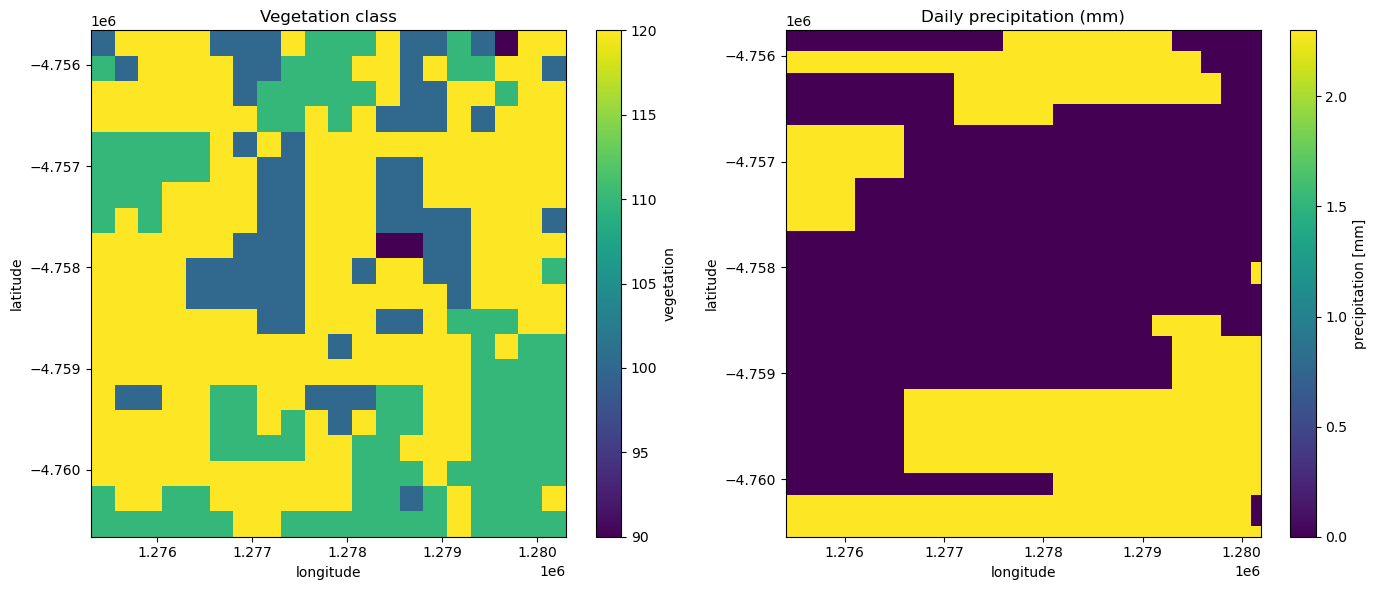

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
vegetation_xr.vegetation.plot(ax=ax[0])
ax[0].set_title("Vegetation class")
precipitation_xr.precipitation[dict(time=3)].plot(ax=ax[1])
ax[1].set_title("Daily precipitation (mm)")
ax[1].set_xlabel("longitude")
ax[1].set_ylabel("latitude")
plt.tight_layout()
plt.show()

The vegetation raster is a gridded array of categorical values with information on the type of the dominant vegetation of each pixel.

    - Class 90 : Water and urban areas
    - Class 100: Herbaceous class
    - Class 110: Forest class
    - Class 120: Shrubland class
    
For example, the pixel at location (longitude 1277929.24, latitude -4758284.41) displays a value of 120, meaning that the vegetation at this location is shrubland.

#### What is each raster's resolution (in meters)?

The resolution is defined as the distance between the centres of 2 neighbour pixels.

### Assumptions
* Let's assume that coordinates are provided in meters and represents the center of each pixel. 
* for exemple (longitude 1277929.24, latitude -4758284.41) are in meters and represents the center of the associated pixel. 
* Assuming that pixels are squares and the resolution is constant in the raster whatever the used pixels for computation.
* So, the resolution is simply the distance between two centers.

In [35]:
### coordinates labels extraction for each raster 
vegetation_lat = vegetation_xr.latitude.values               # latitude array values for vegetation raster
vegetation_long = vegetation_xr.longitude.values
precipitation_lat = precipitation_xr.latitude.values
precipitation_long = precipitation_xr.latitude.values

### let's take the first two coordinates for each raster since resolution is constant for all centers
x1, x2 = vegetation_lat[0],vegetation_lat[1]              # for vegetation raster
y1, y2 = vegetation_long[0],vegetation_long[1]

z1, z2 =  precipitation_lat[0],precipitation_lat[1]      # for precipitation raster
w1,w2 = precipitation_long[0],precipitation_long[1]

In [36]:
### Distance calculation using euclidean distance 
vegetation_resolution = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
precipitation_resolution = int(round(np.sqrt((z2 - z1)**2 + (w2 - w1)**2)))

In [27]:
vegetation_resolution                 # the resolution for vegetation raster 

354

In [37]:
precipitation_resolution           # the resolution for precipitation raster 

141

In [38]:
# let's change our code with two other points (not the first ones) and see if we are going to have the same resolution 

x1, x2 = vegetation_lat[4],vegetation_lat[5]               # here, we took the 4th and 5th labels
y1, y2 = vegetation_long[4],vegetation_long[5]             # here, we took the 4th and 5th labels

z1, z2 =  precipitation_lat[4],precipitation_lat[5]
w1,w2 = precipitation_long[4],precipitation_long[5]

vegetation_resolution_2 = int(round(np.sqrt((x2 - x1)**2 + (y2 - y1)**2)))
precipitation_resolution_2 = int(round(np.sqrt((z2 - z1)**2 + (w2 - w1)**2)))

In [39]:
vegetation_resolution_2 

354

In [40]:
precipitation_resolution_2

141

Conclusion : we have always the same values, which valides our hypothesis in calculating the resolution. 

In [41]:
assert isinstance(vegetation_resolution, int)
assert isinstance(precipitation_resolution, int)

# 3. Manipulate rasters

### 3.1 Change rasters' resolution

our task is to get the precipitation for all grid cells in the forest class (value of 110). Unfortunately, the 2 rasters do not have the same resolution. our task will be to reindex the 2 rasters at the **same** resolution.

The resolution of each raster should be the finest one out of the 2 intial datasets.

To downscale (move from coarse to finer resolution), I will use the function `xarray.interp()`: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp.html

* In our case, vegetation_resolution > precipitation_resolution according to the last question. 
* we will downscale the vegetation raster to the resolution of the precipitation raster. 
* To do so, we will interpolate the values of vegetation (90, 100, 110, 120) to the finer resolution of precipitatin.
* However, interpolation can render values of vegetation outside the ensemble of (90, 100, 110, 120)
* To avoid this, we will interpolate using the nearest method. 

In [46]:
vegetation_downscaled_xr = vegetation_xr.interp(latitude = precipitation_xr.latitude,#align the vegetation dataset on the same latitude of precipitation
                                                longitude = precipitation_xr.longitude, method = 'nearest') 

precipitation_downscaled_xr =  precipitation_xr   ## we will keep it as it has the finner resolution

In [47]:
### verify if the new vegetation raster has the same resoltion of precipitation
int(round(np.sqrt((vegetation_downscaled_xr.latitude.values[1]- vegetation_downscaled_xr.latitude.values[0])**2 
                  + (vegetation_downscaled_xr.longitude.values[1]- vegetation_downscaled_xr.longitude.values[0])**2)))

141

The new vegetation raster has the same resolution of precipitation raster

In [70]:
### now I want to check visually if the values taken by the downscaled vegetation raster are within (90, 100, 110, 120) only
### I'll flatten my ndarray to apply set function
### a set keep only unique values 
set(vegetation_downscaled_xr.vegetation.data.flatten())

{90.0, 100.0, 110.0, 120.0}

So here, I have just values in (90, 100, 110, 120) in my new vegetation raster

In [72]:
### Convert the type of vegetation_downscaled_xr.vegetation to int values 
vegetation_downscaled_xr.vegetation.data = vegetation_downscaled_xr.vegetation.data.astype(int)

In [73]:
set(vegetation_downscaled_xr.vegetation.data.flatten())

{90, 100, 110, 120}

In [74]:
assert isinstance(vegetation_downscaled_xr, xr.Dataset)
assert isinstance(precipitation_downscaled_xr, xr.Dataset)

## 3.2 Compute mean precipitation

The client has forests that span over all the area showed by the raster, which means that all grid cells in forest class belong to the client.

the task is to compute the mean daily precipitation for grid cells only in **forest class**. I will  use the function [`xarray.where()`](https://docs.xarray.dev/en/stable/generated/xarray.where.html).

The output will be a dataframe `df_rain_historical` with the dates as index with name `Date` and the column daily precipitation renamed `daily_rain`. I will use the function [`xarray.to_dataframe()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_dataframe.html)

In [188]:
## we apply a filter on forest class 110 and then we apply mean reduction on latitude and longitude 
daily_rain_xr = precipitation_downscaled_xr.where(vegetation_downscaled_xr.vegetation==110).mean(dim = 'latitude').mean(dim = 'longitude')
## compute the time series dataframe
df_rain_historical = daily_rain_xr.to_dataframe().drop('spatial_ref', axis = 1).rename(columns = {'precipitation':'daily_rain'}).rename_axis('Date')
df_rain_historical

,daily_rain
Date,
1950-01-01,0.000000
1950-01-02,0.000000
1950-01-03,5.899997
1950-01-04,2.300001
1950-01-05,0.000000
...,...
2022-05-11,20.099991
2022-05-12,7.200001
2022-05-13,24.800001


In [127]:
assert df_rain_historical.index.name == "Date"

## 3.3 Next steps

The previous task helped you to compute the daily precipitation for one day at the client's locations. We actually have access to 70 years of historical data and that's the object of the next steps. The data from the previous part has been extracted at the client location into a dataframe that you will use from now on

# 4. Pricing

## 4.1 Context

The client is looking to be covered against excess of rain.

The client wishes to receive a payout under the following conditions:
+ Depends on the cumulative rainfall (mm) over the season.
+ Linear payout starting at a deductible of 650 mm and limit of 750 mm with a payout of AUD 500,000.

It means that 
+ If the cumulative rainfall is below 650 mm, the client receives nothing.
+ If the cumulative rainfall is above 750 mm, the client receives the max payout of AUD 500,000 no matter the loss.
+ If the cumulative rainfall is between 650 and 750 mm, the payout is linear, slope of AUD 5,000 per mm. For example, if the cumulative rainfall is 700 mm, the payout would be AUD 250,000.


## 4.2 Data

We have access to the cumulative rainfall (in millimeters-mm) each day since 1950 January 1st using the task before.

## 4.3 Preprocessing

### 4.3.1 Filtering

**Risk period**

The client would like to be covered from the 1st of December of a given year until 1st of March of the following year (**not included**).

**steps**
- Filter the historical dates to keep only the ones in the risk periods. ⚠️ we should not have incomplete seasons. ⚠️
- Remove the rows with the date equal to February 29th.
- Create a `season` column, the value of the season is the year corresponding to the 1st of December. For example, for the given risk period 1st of December 2021 - 1st of March 2022, the season is 2021.

In [189]:
df = df_rain_historical      ## takes the previous dataset in the previous section

In [190]:
df_ = df.reset_index()    ### to facilitate manipulation on pandas, I prefer to move Date from index to column

df_rain_historical = df_[df_.Date.dt.month.isin([12,1,2])]    ### take only the covered season of winter 

index_02_29 = df_rain_historical[(df_rain_historical.Date.dt.month ==2) & 
                                         (df_rain_historical.Date.dt.day ==29)].index      # the indexes of the 29/02 in the dataset 

df_rain_historical = df_rain_historical.drop(index_02_29)            ## drop by indexes 

df_rain_historical['season'] = None             ### create a season column to fill according to conditions with loc

### if the month is 1 or 2, then the season will be the previous year 
## if the month is 12, then the season will be the current year 

df_rain_historical.loc[(df_rain_historical.Date.dt.month == 1)|
                          (df_rain_historical.Date.dt.month == 2), 'season' ] = df_rain_historical.Date.dt.year -1   

df_rain_historical.loc[(df_rain_historical.Date.dt.month == 12), 'season' ] = df_rain_historical.Date.dt.year   

In [191]:
df_rain_historical.head()

,Date,daily_rain,season
0,1950-01-01,0.000000,1949
1,1950-01-02,0.000000,1949
2,1950-01-03,5.899997,1949
3,1950-01-04,2.300001,1949
4,1950-01-05,0.000000,1949


In [192]:
### since we don't have the daily rain values of 12-1949, 1949 is an incomplete season, we should remove it
df_rain_historical = df_rain_historical.drop(df_rain_historical[df_rain_historical.season ==1949].index)

In [193]:
### I want to verify here that I have only complete seasons 
### Compelete season are 3 months long seasons. 
### I will perform a group by season and count months of each season using lambda function
### I should have only 3 months across all seasons. 
df_rain_historical.groupby('season')['Date'].apply(lambda x: x.dt.month.nunique()).unique()

array([3], dtype=int64)

In [194]:
df_rain_historical.set_index('Date', inplace= True)    ### here, I set Date in the index

In [195]:
assert list(df_rain_historical.columns) == ["daily_rain", "season"]

### 4.3.2 Regroup by season

**steps**

- Create a new dataframe `df_cum_rain` by regrouping by season and by computing the cumulative rainfall over the risk period.
- Rename the column `daily_rain` by `cum_rain`.

In [199]:
df_cum_rain = df_rain_historical.groupby('season')['daily_rain'].sum().reset_index().rename(columns = {'daily_rain' :'cum_rain'})
df_cum_rain

,season,cum_rain
0,1950,682.499878
1,1951,228.800003
2,1952,479.200043
3,1953,612.900024
4,1954,514.200073
...,...,...
67,2017,345.799988
68,2018,243.899918
69,2019,243.800018
70,2020,128.800003


## 4.4 Compute payouts

Using the current values of `cum_rain`, we will now compute the historical payouts.

**steps**
- Design a function that computes the payouts using the structure defined above.
- Compute historical payouts since 1950 by creating a new dataframe `df_historical_payouts` with column `hist_payouts`. 

The resulting mean value of historical payouts is called **burning cost** and corresponds to the mean payout the client would have received based on the historical data. This is an important metrics in the design of insurance covers.

In [217]:
### Define the payout function

def payout(x):   
    if x < 650:             ### If the cumulative rainfall is below 650 mm, the client receives nothing
        return 0
    if x > 750:            ### If the cumulative rainfall is above 750 mm, the client receives the max payout of AUD 500,000 no matter the loss
        return 500000
    return round(5000*(x-650), 2)      ### true for 700 

df_cum_rain['hist_payouts'] = df_cum_rain['cum_rain'].apply(payout)
df_historical_payouts = df_cum_rain[['hist_payouts', 'season']]
df_historical_payouts

,hist_payouts,season
0,162499.39,1950
1,0.00,1951
2,0.00,1952
3,0.00,1953
4,0.00,1954
...,...,...
67,0.00,2017
68,0.00,2018
69,0.00,2019
70,0.00,2020


## 4.5 Weighting

### 4.5.1 Year type

We actually have access to historical yearly forecasts that states if the year was supposed to be rainy or not. There are 3 predictions:
- neutral
- dry
- rainy

All the information is stored in the dataframe `df_year_type`.

We will use this information to compute a weighted payouts using next year forecast.

In [212]:
year_type_data_path = DATA_PATH / "pricing" / "year_type_historical.csv"

In [215]:
df_year_type = (
    pd.read_csv(year_type_data_path, index_col=0)
    .rename(columns={"Year": "season"})
    .set_index("season")
)
df_year_type.head()

,year_type
season,
1950,rainy
1951,dry
1952,neutral
1953,dry
1954,rainy


**steps**

Compute the burning cost of each of the year type

In [253]:
df = df_historical_payouts.merge(df_year_type, how = 'inner', on= 'season')
dw = df.groupby('year_type')['hist_payouts'].mean().reset_index().rename(columns = {'hist_payouts':'burning_cost'})
dw

,year_type,burning_cost
0,dry,0.000000
1,neutral,26315.789474
2,rainy,52277.752963


* In Dry years, the client receives no payout because we don't exceed 650 mm over the years (en moyennne)
* In neutral years, the payout is less than in the rainy years. 

### 4.5.2 Next year forecast

The forecast for next year is given in terms of probability for each of the year types:

In [223]:
next_year_forecast = {"dry": 0.58, "neutral": 0.37, "rainy": 0.05}

**Task**

estimate the risk and adjust the burning cost

In [254]:
# let's calculate the expected burning cost of the next year

dw['next_year_forecast'] = next_year_forecast.values()

dw['next_year_expected_payout per year type'] = dw['burning_cost'] * dw.next_year_forecast

dw

,year_type,burning_cost,next_year_forecast,next_year_expected_payout per year type
0,dry,0.000000,0.58,0.000000
1,neutral,26315.789474,0.37,9736.842105
2,rainy,52277.752963,0.05,2613.887648


In [256]:
print(f'The expected payout of the next year is AUD {round(dw["next_year_expected_payout per year type"].sum(), 2)}')

The expected payout of the next year is AUD 12350.73


---
# END OF SCRIPT